# Fake News with Transformers (Transformer Expalinability in the last section)

The implementations are based on ```transformers.ipynb``` with additional transformer explainability section added

## Import dataset

In [ ]:
# !pip install sentencepiece==0.1.94 # restart runtime after installing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import csv
import sys
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Resolves error 'field larger than field limit (131072) as some lines contain text more than 30k words
csv.field_size_limit(sys.maxsize)
df = pd.read_csv("/content/drive/MyDrive/raw_data/raw_data/fulltrain.csv", header = None, engine='python', names=['class','text'])

In [3]:
df.head()

,class,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.0 MB/s eta 0:00:00


## Tokenization & Input Formatting

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [7]:
articles = df.text.values
labels = df["class"].values - 1

In [8]:
print(len(labels))

48854


In [9]:
# Print the original sentence.
print(' Original: ', articles[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(articles[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(articles[0])))

 Original:  A little less than a decade ago, hockey fans were blessed with a slate of games every night, but on Thursday sources confirmed that for the ninth consecutive year NHL players have been locked out, with very slim hopes of an agreement in sight. It seems like just yesterday Martin St. Louis and his Lightning teammates were raising the Stanley Cup, high school hockey coach and onetime ESPN analyst Barry Melrose said. Obviously, Im still hoping the two sides can come together and reach an agreement, but Im starting to think nobody really misses hockey anymore. Nope. Nobody but old Barry. Id still love to catch an Atlanta Thrashers game. Observers have noted that when arena doors do reopen, the NHL will face the perhaps greater challenge of convincing fans to return to hockey instead of watching more popular sports like football, basketball, baseball, and SlamBall. 
Tokenized:  ['A', 'little', 'less', 'than', 'a', 'decade', 'ago', ',', 'hockey', 'fans', 'were', 'blessed', 'with'

In [10]:
max_len = 0
count = {0: 0, 1:0, 2:0, 3:0}
len_sum = {0: 0, 1:0, 2:0, 3:0}
to_summarize = []

for index, article in enumerate(articles):

    input_ids = tokenizer.encode(article, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))
    label = labels[index]
    size = len(input_ids)
    if size > 6000: #1194: 8090 #4000: 531 #3000: 1074 # threshold for summarizing
        to_summarize.append(index)
    count[label] += 1
    len_sum[label] += size

for i in range(4):
    print(len_sum[i] / count[i])
print('Max article length: ', max_len)
print('Propagandas to summarize: ', len(to_summarize)) 

Token indices sequence length is longer than the specified maximum sequence length for this model (1029 > 512). Running this sequence through the model will result in indexing errors


401.3150850715455
245.91155286660904
1194.5073307218802
593.4103051525763
Max article length:  215311
Propagandas to summarize:  208


In [11]:
# summary of propagandas, not used due to long running time

# from transformers import T5ForConditionalGeneration, T5Tokenizer 
 
# def summarize_text(text, model_name="t5-small", max_length=100): 
#     tokenizer = T5Tokenizer.from_pretrained(model_name) 
#     model = T5ForConditionalGeneration.from_pretrained(model_name) 
 
#     # Prepend "summarize: " to the text, as T5 model expects it for summarization tasks 
#     input_text = "summarize: " + text 
 
#     # Encode the text and generate summary 
#     input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512) 
#     summary_ids = model.generate(input_ids, num_beams=4, no_repeat_ngram_size=2, min_length=30, max_length=max_length, early_stopping=True) 
     
#     # Decode the summary and return 
#     summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True) 
#     return summary


In [12]:
input_ids = []
attention_masks = []
 
for index, article in enumerate(articles):
    # if labels[index] == 2: # for summarize, not used
    # if index in to_summarize:
    #     processed_article = summarize_text(article)
    # else:
    processed_article = article

    encoded_dict = tokenizer.encode_plus(
                        processed_article,                    
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print article 0, now as a list of IDs.
print('Original: ', articles[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  A little less than a decade ago, hockey fans were blessed with a slate of games every night, but on Thursday sources confirmed that for the ninth consecutive year NHL players have been locked out, with very slim hopes of an agreement in sight. It seems like just yesterday Martin St. Louis and his Lightning teammates were raising the Stanley Cup, high school hockey coach and onetime ESPN analyst Barry Melrose said. Obviously, Im still hoping the two sides can come together and reach an agreement, but Im starting to think nobody really misses hockey anymore. Nope. Nobody but old Barry. Id still love to catch an Atlanta Thrashers game. Observers have noted that when arena doors do reopen, the NHL will face the perhaps greater challenge of convincing fans to return to hockey instead of watching more popular sports like football, basketball, baseball, and SlamBall. 
Token IDs: tensor([  101,   138,  1376,  1750,  1190,   170,  4967,  2403,   117,  4700,
         3899,  1127, 1586

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

43,968 training samples
4,886 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# download the library for first explainability method
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
import os
os.chdir(f'./Transformer-Explainability')


Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 386 (delta 3), reused 2 (delta 0), pack-reused 377
Receiving objects: 100% (386/386), 3.85 MiB | 2.73 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
!pip install captum


In [ ]:
from transformers import BertTokenizer
from transformers import BertTokenizer
from transformers import AutoTokenizer
import torch



In [ ]:
from transformers.modeling_outputs import SequenceClassifierOutput

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = 4, 

    output_attentions = False, 
    output_hidden_states = False, 
)

model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss = outputs.loss
            logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,374.    Elapsed: 0:00:19.
  Batch    80  of  1,374.    Elapsed: 0:00:41.
  Batch   120  of  1,374.    Elapsed: 0:00:57.
  Batch   160  of  1,374.    Elapsed: 0:01:12.
  Batch   200  of  1,374.    Elapsed: 0:01:28.
  Batch   240  of  1,374.    Elapsed: 0:01:44.
  Batch   280  of  1,374.    Elapsed: 0:02:01.
  Batch   320  of  1,374.    Elapsed: 0:02:17.
  Batch   360  of  1,374.    Elapsed: 0:02:33.
  Batch   400  of  1,374.    Elapsed: 0:02:48.
  Batch   440  of  1,374.    Elapsed: 0:03:04.
  Batch   480  of  1,374.    Elapsed: 0:03:20.
  Batch   520  of  1,374.    Elapsed: 0:03:35.
  Batch   560  of  1,374.    Elapsed: 0:03:51.
  Batch   600  of  1,374.    Elapsed: 0:04:07.
  Batch   640  of  1,374.    Elapsed: 0:04:22.
  Batch   680  of  1,374.    Elapsed: 0:04:38.
  Batch   720  of  1,374.    Elapsed: 0:04:54.
  Batch   760  of  1,374.    Elapsed: 0:05:10.
  Batch   800  of  1,374.    Elapsed: 0:05:25.
  Batch   840  of

In [ ]:

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.141265,0.059603,0.981618,0:09:10,0:00:18
2,0.028089,0.056357,0.986111,0:09:05,0:00:18


## Evaluate on Test Set

In [ ]:
# # load existing weights if necessary
# weights_dir = '/content/drive/MyDrive/raw_data/4_epochs'

# model = BertForSequenceClassification.from_pretrained(weights_dir, local_files_only=True)

# # Tell pytorch to run this model on the GPU.
# model.to(device)

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/MyDrive/raw_data/raw_data/balancedtest.csv", header=None, names=['label', 'articles'])

# Report the number of articles.
print('Number of test articles: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
articles = df.articles.values
labels = df.label.values - 1

# Tokenize all of the articles and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for article in articles:
    encoded_dict = tokenizer.encode_plus(
                        article,                      # Article to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test articles: 3,000



The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test articles...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      # print(b_input_ids)
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,000 test articles...
    DONE.


Accuracy: 0.657
F1 Score: 0.6043634038472899


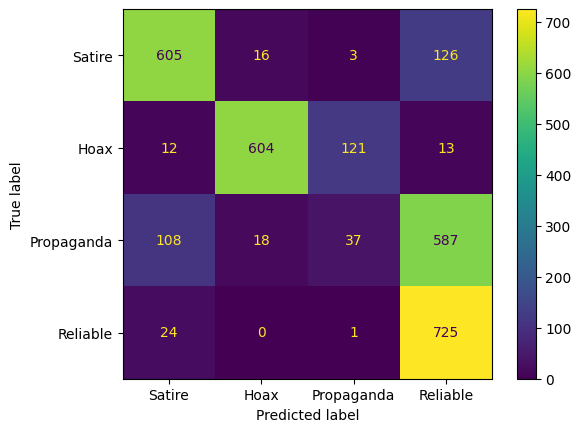

In [ ]:
# 2 epochs, 64
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate accuracy and F1 score
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels)
pred_labels = np.argmax(predictions, axis=1)
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("Accuracy:", acc)
print("F1 Score:", f1)
classifications = ["Satire", "Hoax", "Propaganda", "Reliable"]
# print(true_labels)
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifications)
disp.plot()
plt.show()

## Save Model

In [ ]:
import os

output_dir = '/content/drive/MyDrive/raw_data/2_epochs_length_64'
# output_dir = './'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/raw_data/2_epochs_length_64


('/content/drive/MyDrive/raw_data/2_epochs_length_64/tokenizer_config.json',
 '/content/drive/MyDrive/raw_data/2_epochs_length_64/special_tokens_map.json',
 '/content/drive/MyDrive/raw_data/2_epochs_length_64/vocab.txt',
 '/content/drive/MyDrive/raw_data/2_epochs_length_64/added_tokens.json',
 '/content/drive/MyDrive/raw_data/2_epochs_length_64/tokenizer.json')

## Transformer Explainability

1. First method (a hybrid of gradient based and attribution propagation methods)

In [ ]:
# import the BERT wrapper implemented by the explainability lib
from transformers import BertTokenizer
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator
from BERT_explainability.modules.BERT.BertForSequenceClassification import BertForSequenceClassification
from transformers import BertTokenizer
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator
from transformers import AutoTokenizer

from captum.attr import (
    visualization
)
import torch

from transformers import BertPreTrainedModel
from BERT_explainability.modules.layers_ours import *
from BERT_explainability.modules.BERT.BERT import BertModel
from torch.nn import CrossEntropyLoss, MSELoss

class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = Dropout(config.hidden_dropout_prob)
        self.classifier = Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        """
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def relprop(self, cam=None, **kwargs):
        cam = self.classifier.relprop(cam, **kwargs)
        cam = self.dropout.relprop(cam, **kwargs)
        cam = self.bert.relprop(cam, **kwargs)
        # print("conservation: ", cam.sum())
        return cam

In [ ]:
# load back saved weights to the new explainability model
model = BertForSequenceClassification.from_pretrained(output_dir, local_files_only=True) 

# Tell pytorch to run this model on the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (add1): Add()
      (add2): Add()
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (matmul1): MatMul()
              (matmul2): MatMul()
              (softmax): Softmax(dim=-1)
              (add): Add()
       

In [ ]:
explanations = Generator(model)

classifications = ["Satire", "Hoax", "Propaganda", "Reliable"]

idx=10 # select the test article to analyse
test_article = articles[idx]
# print(test_article)
encoding = tokenizer.encode_plus(
                        test_article,                      # Article to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
input_ids = encoding['input_ids'].cuda()
attention_mask = encoding['attention_mask'].cuda()

true_class = labels[idx]


# generate an explanation for the input
expl = explanations.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, start_layer=0)[0]
# normalize scores
expl = (expl - expl.min()) / (expl.max() - expl.min())

# get the model classification
output = torch.nn.functional.softmax(model(input_ids=input_ids, attention_mask=attention_mask)[0], dim=-1)
classification = output.argmax(dim=-1).item()
# get class name
class_name = classifications[classification]

tokens = tokenizer.convert_ids_to_tokens(input_ids.flatten())
print([(tokens[i], expl[i].item()) for i in range(len(tokens))])
vis_data_records = [visualization.VisualizationDataRecord(
                                expl,
                                output[0][classification],
                                classification,
                                true_class,
                                true_class,
                                1,       
                                tokens,
                                1)]

[('[CLS]', 0.0), ('In', 0.04069263115525246), ('a', 0.11560693383216858), ('poll', 0.2040676474571228), ('taken', 0.007898584939539433), ('on', 0.01440433133393526), ('Tuesday', 0.06334768235683441), ('night', 0.15757006406784058), (',', 0.43095704913139343), ('a', 0.0543011799454689), ('wide', 0.06761441379785538), ('majority', 0.06750386953353882), ('of', 0.030743127688765526), ('Americans', 1.0), ('said', 0.041193604469299316), ('that', 0.03858424723148346), ('they', 0.04335566610097885), ('now', 0.0822354406118393), ('believe', 0.02255755476653576), ('that', 0.0273846834897995), ('they', 0.016272220760583878), ('could', 0.022827332839369774), ('be', 0.00158801453653723), ('elected', 0.015752745792269707), ('to', 0.008637737482786179), ('the', 0.005675693042576313), ('United', 0.09013515710830688), ('States', 0.057716719806194305), ('Senate', 0.027650950476527214), ('.', 0.06386654078960419), ('The', 0.048614464700222015), ('results', 0.061965346336364746), ('reflected', 0.036532197

In [ ]:
visualization.visualize_text(vis_data_records)
print("Predicted: " + class_name, "Actual: " + classifications[true_class]) # fine-tuned 2 epochs, 64 length

Predicted: Satire Actual: Satire


In [ ]:
visualization.visualize_text(vis_data_records)
print("Predicted: " + class_name, "Actual: " + classifications[true_class]) # fine-tuned 4 epochs, 256 length

Predicted: Satire Actual: Satire


In [ ]:
visualization.visualize_text(vis_data_records)
print("Predicted: " + class_name, "Actual: " + classifications[true_class]) # fine-tuned 4 epochs, 256 length

Predicted: Reliable Actual: Propaganda


In [ ]:
visualization.visualize_text(vis_data_records)
print("Predicted: " + class_name, "Actual: " + classifications[true_class]) # fine-tuned 4 epochs

Predicted: Satire Actual: Propaganda


In [ ]:
visualization.visualize_text(vis_data_records)
print("Predicted: " + class_name, "Actual: " + classifications[true_class]) # fine-tuned 4 epochs

Predicted: Reliable Actual: Satire


In [ ]:
visualization.visualize_text(vis_data_records)
print("Predicted: " + class_name, "Actual: " + classifications[true_class]) # not fine-tuned

Predicted: Propaganda Actual: Satire


2. SHAP method

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 32.2 MB/s eta 0:00:00


In [ ]:
# based on SHAP library
import shap
import transformers
import numpy as np
import scipy as sp

idx=10 # select the test article to analyse
test_article = articles[idx]
print(test_article)

def f(test_article): 
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=64, truncation=True) for v in test_article]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

test_input = {'label':[labels[idx]], 'text':[test_article]}

shap_values = explainer(test_input, fixed_context=1)

 In a poll taken on Tuesday night, a wide majority of Americans said that they now believe that they could be elected to the United States Senate. The results reflected a renewed sense of the inclusiveness of the American political system, as those surveyed said that they believed that anyone could serve in the Senate regardless of intelligence, the ability to speak, or any other qualifications whatsoever. While those responses indicated that, as of Tuesday night, at least, Americans were energized about the possibility of their future careers in Washington, other results were not so encouraging. Nineteen per cent of those surveyed said that they could not respond to the poll questions because they were still in a state of shock, while fourteen per cent agreed with the statement WTF??? 


  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
shap.plots.text(shap_values)